In [1]:
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.0 MB/s eta 0:00:00


In [2]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# model imports
import efficientnet.keras as efn
from tensorflow.keras.callbacks import Callback
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision

# evaluation imports
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [3]:
# mount to gdrive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
import os
from shutil import copyfile
os.makedirs('images/NORMAL', exist_ok=True)
os.makedirs('images/PNEUMONIA', exist_ok=True)

base_path = '/content/drive/My Drive/xray_pneumonia_train'

for path in ['/train']:
  for dirname, _, filenames in os.walk(base_path+path):
      for i, file in enumerate(filenames):
          img_class = dirname.split('/')[6]
          copyfile(os.path.join(dirname, file), 'images/' + img_class + '/' + file)

In [5]:
for dirname, _, filenames in os.walk('images'):
    if(len(dirname.split("/")) > 1):
        print(dirname + " has " + str(len(filenames)) + " files")

images/PNEUMONIA has 0 files
images/NORMAL has 0 files


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from shutil import rmtree

#rmtree('train') # Remove existing, if re-run
#rmtree('test') # Remove existing, if re-run

os.makedirs('model-train/NORMAL', exist_ok=True)
os.makedirs('model-train/PNEUMONIA', exist_ok=True)
os.makedirs('model-test/NORMAL', exist_ok=True)
os.makedirs('model-test/PNEUMONIA', exist_ok=True)

# Split NORMAL
train, test = train_test_split(os.listdir('images/NORMAL'), 
                               test_size=0.2, 
                               random_state=42)
for img in train:
    copyfile(os.path.join('images/NORMAL/', img), 
             os.path.join('model-train/NORMAL/', img))
for img in test:
    copyfile(os.path.join('images/NORMAL/', img), 
             os.path.join('model-test/NORMAL/', img))

# Split PNEUMONIA
train, test = train_test_split(os.listdir('images/PNEUMONIA'), 
                               test_size=0.2, 
                               random_state=42)
for img in train:
    copyfile(os.path.join('images/PNEUMONIA/', img), 
             os.path.join('model-train/PNEUMONIA/', img))
for img in test:
    copyfile(os.path.join('images/PNEUMONIA/', img), 
             os.path.join('model-test/PNEUMONIA/', img))

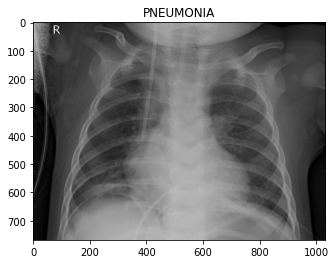

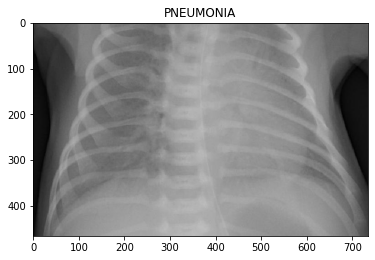

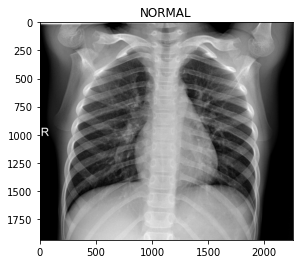

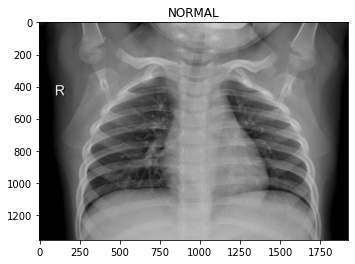

In [8]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

for dirname, _, filenames in os.walk('model-train'):
    for i, file in enumerate(filenames):
        if(i > 1):
            break
        plt.imshow(mpimg.imread(os.path.join(dirname, file)), cmap='gray')
        plt.title(dirname.split('/')[1])
        plt.show()

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SIZE = 128
BATCH = 64

# image augmentations
image_gen = ImageDataGenerator(rescale=1./255,
                                rotation_range=5,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                validation_split=0.2)

# flow_from_directory generators
train_generator = image_gen\
    .flow_from_directory('model-train',
                        target_size=(SIZE, SIZE),
                        class_mode="binary",
                        batch_size=BATCH,
                        subset='training')

validation_generator = image_gen\
    .flow_from_directory('model-train',
                        target_size=(SIZE, SIZE),
                        class_mode="binary",
                        batch_size=BATCH,
                        subset='validation')

Found 3352 images belonging to 2 classes.
Found 837 images belonging to 2 classes.


In [10]:
# Callbacks
## Keep the best model
mc = ModelCheckpoint('model.hdf5', 
                     save_best_only=True, 
                     verbose=0, 
                     monitor='val_loss', 
                     mode='min')

## Reduce learning rate if it gets stuck in a plateau
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.3, 
                        patience=3, 
                        min_lr=0.000001, 
                        verbose=1)

# Model
## Define the base model with EfficientNet weights
model = efn.EfficientNetB4(weights = 'imagenet', 
                           include_top = False, 
                           input_shape = (SIZE, SIZE, 3))

## Output layer
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

## Compile and run
model = Model(inputs=model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(), Precision()])

model_history = model.fit(train_generator,
                            validation_data=validation_generator,
                            steps_per_epoch=train_generator.n/BATCH,
                            validation_steps=validation_generator.n/BATCH,
                            epochs=15,
                            verbose=1,
                            callbacks=[mc, rlr])

71892840/71892840 [==============================] - 1s 0us/step
Epoch 1/15
52/52 [==============================] - 1130s 21s/step - loss: 0.1989 - accuracy: 0.9209 - recall: 0.9429 - precision: 0.9502 - val_loss: 0.3682 - val_accuracy: 0.9355 - val_recall: 0.9952 - val_precision: 0.9239 - lr: 0.0010
Epoch 2/15
52/52 [==============================] - 983s 19s/step - loss: 0.0865 - accuracy: 0.9675 - recall: 0.9791 - precision: 0.9771 - val_loss: 0.0965 - val_accuracy: 0.9594 - val_recall: 0.9486 - val_precision: 0.9966 - lr: 0.0010
Epoch 3/15
52/52 [==============================] - 971s 19s/step - loss: 0.0558 - accuracy: 0.9797 - recall: 0.9875 - precision: 0.9852 - val_loss: 0.0886 - val_accuracy: 0.9725 - val_recall: 0.9791 - val_precision: 0.9838 - lr: 0.0010
Epoch 4/15
52/52 [==============================] - 967s 18s/step - loss: 0.0510 - accuracy: 0.9809 - recall: 0.9871 - precision: 0.9871 - val_loss: 0.1033 - val_accuracy: 0.9642 - val_recall: 0.9984 - val_precision: 0.9554

In [11]:
# load the best model
model.load_weights("model.hdf5")

<Figure size 432x288 with 0 Axes>

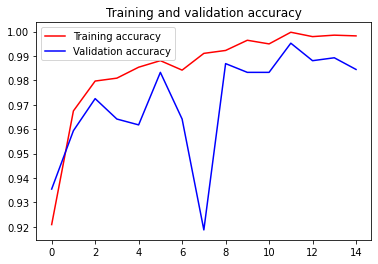

<Figure size 432x288 with 0 Axes>

In [12]:
# plot training and validation accuracy by epoch
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=5,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

test_generator = test_datagen.flow_from_directory(
    directory="model-test",
    target_size=(SIZE, SIZE),
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH
)

preds = model.predict_generator(generator=test_generator) # get proba predictions
labels = 1*(preds > 0.5) # convert proba to classes

Found 1048 images belonging to 2 classes.


<ipython-input-14-9a4f14f4b27f>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(generator=test_generator) # get proba predictions


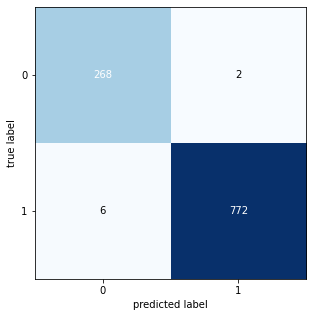

In [15]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
CM = confusion_matrix(test_generator.classes, labels)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [16]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, labels))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       270
           1       1.00      0.99      0.99       778

    accuracy                           0.99      1048
   macro avg       0.99      0.99      0.99      1048
weighted avg       0.99      0.99      0.99      1048



In [17]:
from sklearn.metrics import precision_score, accuracy_score

# Calculate the precision
precision = precision_score(test_generator.classes, labels)
print("Precision: ", precision)

# Calculate the accuracy
accuracy = accuracy_score(test_generator.classes, labels)
print("Accuracy: ", accuracy)

Precision:  0.9974160206718347
Accuracy:  0.9923664122137404


https://www.kaggle.com/code/bluewizard/predict-pneumonia-keras-efficientnet-98-acc/notebook#Addressing-some-issues-with-the-original-dataset